## Use pretained model from the complete vggFace
In this script, we do a finer transer learning, borrowing training results from a complete vggFace.

In [1]:
# pip install keras_vggface
from keras_vggface.vggface import VGGFace

# Based on VGG16 architecture -> old paper(2015)
# Method: Deep Face Recognition (trained on 982k images, however, the actual training hours were not reported)
vggface = VGGFace(model='vgg16') 

Using TensorFlow backend.


In [2]:
from keras.layers import Input
from keras_vggface.vggface import VGGFace

# Convolution Features
vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max

In [3]:
print vggface.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [4]:
print vgg_features.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

Recall that we dumped the resized images, with size 224x224, in the file "FaceRecog01_*."

In [5]:
# load training and test data
import pickle
import numpy as np
from sklearn.preprocessing import label_binarize

data_train = pickle.load(open("data_dumped/image_data_train224.pkl","rb"))
data_test = pickle.load(open("data_dumped/image_data_test224.pkl","rb"))
class_list = pickle.load(open("data_dumped/class_list.pkl", "rb"))

X_train = np.array([x[0]/255. for x in data_train])
X_test = np.array([x[0]/255. for x in data_test])

Y_train = np.array([x[1] for x in data_train])
Y_test = np.array([x[1] for x in data_test])

Y_train_one_hot = label_binarize(np.array([x[1] for x in data_train]),class_list)
Y_test_one_hot = label_binarize(np.array([x[1] for x in data_test]), class_list)

print X_train.shape
print Y_train.shape
print X_test.shape
print Y_test.shape

(93, 224, 224, 3)
(93,)
(25, 224, 224, 3)
(25,)


In [6]:
# Referring to the keras_vggface [github](https://github.com/rcmalli/keras-vggface), the prediction part
X_train_embedding = vgg_features.predict(X_train)
X_test_embedding = vgg_features.predict(X_test)

In [7]:
from sklearn.linear_model import LogisticRegression as LR

print X_train_embedding.shape
print X_test_embedding.shape

print Y_test

# short cut to only train the last layer
model_lr = LR()
model_lr.fit(X_train_embedding, Y_train)
print "training accuracy: ", model_lr.score(X_train_embedding, Y_train)
print "test accuracy: ", model_lr.score(X_test_embedding, Y_test)

(93, 512)
(25, 512)
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'mindy_kaling' 'mindy_kaling' 'mindy_kaling' 'mindy_kaling'
 'mindy_kaling']
training accuracy:  0.989247311827957
test accuracy:  1.0


/Users/lzq/anaconda3/envs/py27_faceRec/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/lzq/anaconda3/envs/py27_faceRec/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Conclusion
Under the framework of **transfer learning**, we borrowed the excellent training result from vggface16, and acquire an extremely high testing accuracy on our **small** dataset. The test accuracy is amazingly 1.0

## Connect all the components

In [8]:
import cv2
import os
import matplotlib.pyplot as plt

%matplotlib inline
# preprocessing data, locate the faces
# given the picture, retate it from -60 to 60, find the face with the best matching score
# crop the one, return the cropped face

def rotate_image_without_crop(image, angle):
    
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2., h / 2.)
 
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    return cv2.warpAffine(image, M, (nW, nH))

def crop_image(img, faceR):
    (x, y, w, h) = faceR
    return img[y:y+h, x:x+w].copy()

def detect_face(image):
#     cascadePath = os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_default.xml")

    cascadePath = os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_alt.xml")
    result = None
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier(cascadePath)
    
    angle_range = np.arange(-60, 60, 5)
    
    best_face = None
    best_angle = None
    max_weight = 0
    for angle in angle_range:
        imageGray_rotated = rotate_image_without_crop(imageGray, angle)
        # there may be multiple faces in a pic
        faceRects, rejectLevels, levelWeights = cascade.detectMultiScale3(imageGray_rotated, scaleFactor=1.05, minNeighbors=3, minSize=(5,5), outputRejectLevels=True)
    
        if len(faceRects) <= 0:
            continue
        else:
            # for all the faces detected in a pic, find the largest shape one. It is our assumption
            # when doing prediciton, it is of course not a problem to do multiple face detection
            # but in training, it is hard to believe there are two faces of the same person.
            face, weight = max([(faceR, weight) for faceR, weight in zip(faceRects, levelWeights)], key = lambda x: x[0][2]*x[0][3]) 
#             print weight, angle
            if (weight > max_weight):
                max_weight = weight
                best_face = face
                best_angle = angle
    
    if(best_face is None):
        return None
    else:
        rotated_img = rotate_image_without_crop(image, best_angle)
        return crop_image(rotated_img, best_face)

## Pilot Test

We load an self-chosen image and determine which one out of the five people in data is the most similar to.

(317, 214, 3)


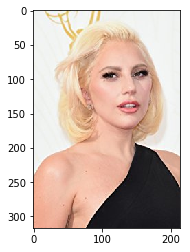

In [9]:
# 1. load someone's iamge, e.g. ladygaga

test_image = cv2.imread('images/ladygaga.jpg')

print test_image.shape

plt.imshow(test_image[:,:,::-1])
plt.show()

In [10]:
detected_face = detect_face(test_image)

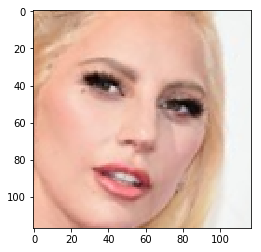

In [11]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.imshow(detected_face[:,:,::-1])
plt.show()

In [12]:
detected_face_resized = cv2.resize(detected_face/255., (224, 224)) # now the dimsion is 224*224*3

In [13]:
detected_face_embedding = vgg_features.predict(np.expand_dims(detected_face_resized, axis=0)) 
# now the dimension is (1,224,224,3)
# because the input must be (N,224, 224,3)

print zip(class_list, model_lr.predict_proba(detected_face_embedding)[0])
print model_lr.predict(detected_face_embedding)

[('ben_afflek', 0.13019129499300236), ('elton_john', 0.13084046239440664), ('jerry_seinfeld', 0.24684487928547183), ('madonna', 0.2878468098174151), ('mindy_kaling', 0.20427655350970397)]
['madonna']


Step backward to see how similar are the photos of ladygaga and madonna.

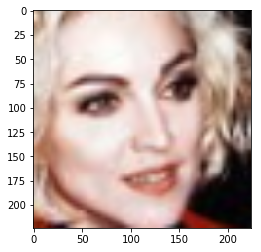

In [14]:
madonna = X_train[Y_train == "madonna"]

plt.imshow(madonna[0][:,:,::-1])
plt.show()

#### Detect the most similar images

In [15]:
from scipy.spatial.distance import cdist

madonna_embedding = vgg_features.predict(madonna)

distances = cdist(detected_face_embedding, madonna_embedding).flatten()

indices = distances.flatten().argsort()

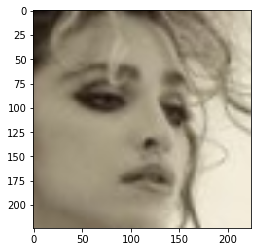

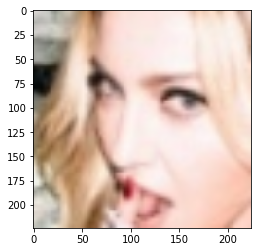

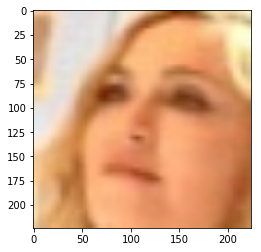

In [16]:
for i in indices[:3]:
    plt.imshow(madonna[i][:,:,::-1])
    plt.show()

## Write everything into a python class
### Detect single face

1. The face in the target image would be detected. Haar Cascade would return the rotated and cropped face with the highest score.


2. Vggface embeddings would calculate for the target face (after step 1) and the faces in the training data, with the labeled predicted by vggface. 


3. Distances between the embeddings of the target face and training date with the predicted label would be caculated. And in this sense, we display the most similar 3 images. (Note that they are the photos of the same person.)

In [17]:
class FaceRecognition():
    def __init__(self, embedding_model, classifier_model, size = (224, 224), X_train = None, Y_train = None):
        self.embedding_model = embedding_model
        self.classifier_model = classifier_model
        self.size = size
        self.X = X_train
        self.Y = Y_train
        if (self.X is not None):
            print "Computing the embedding for training data..."
        self.embedding = self.embedding_model.predict(self.X) if self.X is not None else None
    
    def compute_embedding(self, filename):
        test_image = cv2.imread(filename)
        print "loading image..."
        plt.imshow(test_image[:,:,::-1])
        plt.show()
        print "image loaded\n"
        detected_face = detect_face(test_image)
        if(detected_face is None):
            print "Oops, no face has been detected"
            return None
        else:
            print "Face has been detected"
            plt.imshow(detected_face[:,:,::-1])
            plt.show()
            print ""
            test_face_resized = cv2.resize(detected_face, self.size)/255.
            test_face_embedding = self.embedding_model.predict(np.expand_dims(test_face_resized, axis=0))
        return test_face_embedding
        
        
    def predict_image_single_face(self, filename, return_embedding = False):
        test_face_embedding = self.compute_embedding(filename)
        predictions = zip(class_list, self.classifier_model.predict_proba(test_face_embedding)[0])
        print "Prediction results:"
        for pair in predictions:
            print "Identity: %s, Prob %f" %(pair[0], pair[1])
        max_pair = max(predictions, key = lambda pair: pair[1])

        print "\nThis face has been recognized as: %s with prob %f" %(max_pair[0], max_pair[1])
        if(self.X is not None):
            print ""
            print "\nNow search for the most similar Faces"
            mask = self.Y == max_pair[0]
            distances = cdist(test_face_embedding, self.embedding[mask]).flatten()
            indices = distances.flatten().argsort()[:3]
            print "displaying the top 3 ..."
            for i in indices:
                plt.imshow(self.X[mask][i][:,:,::-1])
                plt.show()
        if(return_embedding):
            return test_face_embedding
        else:
            return None
                

In [18]:
myFaceRecog = FaceRecognition(vgg_features, model_lr, X_train = X_train, Y_train = Y_train)

Computing the embedding for training data...


We use two faces. One is ladygaga, not among our test data. The other is Mandonna, among our test data

loading image...


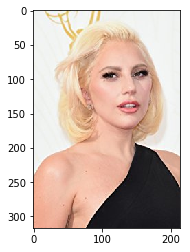

image loaded

Face has been detected


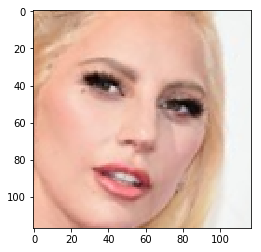


Prediction results:
Identity: ben_afflek, Prob 0.130272
Identity: elton_john, Prob 0.130931
Identity: jerry_seinfeld, Prob 0.246859
Identity: madonna, Prob 0.287881
Identity: mindy_kaling, Prob 0.204057

This face has been recognized as: madonna with prob 0.287881


Now search for the most similar Faces
displaying the top 3 ...


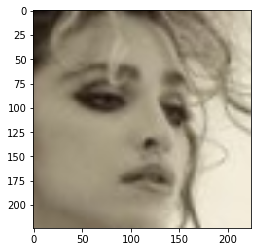

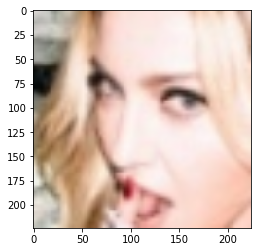

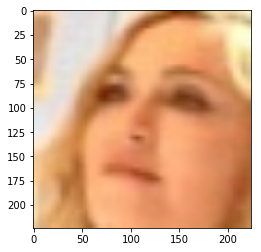

In [19]:
myFaceRecog.predict_image_single_face('images/ladygaga.jpg')

loading image...


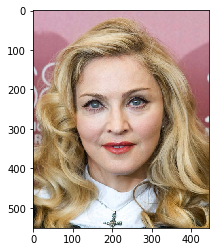

image loaded

Face has been detected


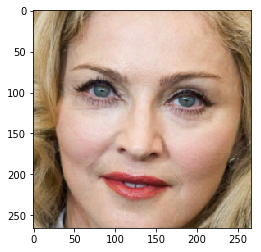


Prediction results:
Identity: ben_afflek, Prob 0.095477
Identity: elton_john, Prob 0.096583
Identity: jerry_seinfeld, Prob 0.094645
Identity: madonna, Prob 0.480314
Identity: mindy_kaling, Prob 0.232981

This face has been recognized as: madonna with prob 0.480314


Now search for the most similar Faces
displaying the top 3 ...


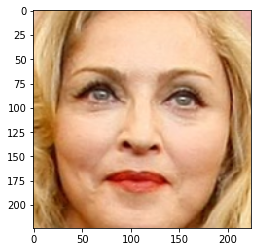

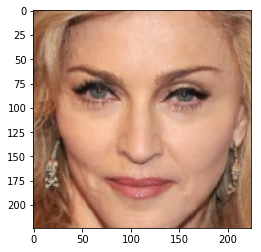

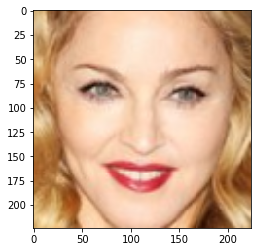

In [20]:
myFaceRecog.predict_image_single_face('images/madonna.jpg')

### Detect multiple faces

1. The faces in the target image would be detected. It is done by the function '.detecMuliScale3'.


2. Vggface embeddings would calculate for the target faces (after step 1) and the faces in the training data, with the labeled predicted by vggface. 


3. Distances between the embeddings of each of the target faces, and training data with the predicted label would be caculated. And in this sense, we display the most similar 3 images of each of the target faces. 

In [21]:
def detect_multiple_face_single(image):
#     cascadePath = os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_default.xml")

    cascadePath = os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_alt.xml")
    result = None
    imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cascade = cv2.CascadeClassifier(cascadePath)
    
    # there may be multiple faces in a pic
    faceRects, rejectLevels, levelWeights = cascade.detectMultiScale3(imageGray, 
                                                                      scaleFactor=1.05, minNeighbors=3, 
                                                                      minSize=(15,15), outputRejectLevels=True)

    result = []
    if len(faceRects) <= 0:
        return []
    
    for rect in faceRects:
        result.append(crop_image(image, rect))
        
    return result

In [22]:
# test_image = cv2.imread("images/madonna_elton.jpg")
# cascadePath = os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_alt.xml")
# result = None
# imageGray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
# cascade = cv2.CascadeClassifier(cascadePath)

# # there may be multiple faces in a pic
# faceRects, rejectLevels, levelWeights = cascade.detectMultiScale3(imageGray, 
#                                                                   scaleFactor=1.05, minNeighbors=3, 
#                                                                   minSize=(15,15), outputRejectLevels=True)

In [23]:
# print faceRects
# print rejectLevels
# print levelWeights

In [24]:
class FaceRecognition_multiple():
    def __init__(self, embedding_model, classifier_model, size = (224, 224), X_train = None, Y_train = None):
        self.embedding_model = embedding_model
        self.classifier_model = classifier_model
        self.size = size
        self.X = X_train
        self.Y = Y_train
        if (self.X is not None):
            print "Computing the embedding for training data..."
        self.embedding = self.embedding_model.predict(self.X) if self.X is not None else None
    
    def compute_embedding(self, filename):
        test_image = cv2.imread(filename)
        print "loading image..."
        plt.imshow(test_image[:,:,::-1])
        plt.show()
        print "image loaded"
        detected_faces = detect_multiple_face_single(test_image)
        if(len(detected_faces) == 0):
            print "Oops, no face has been detected"
            return None
        else:
            temp = []
            print "%d Face has been detected\n" %len(detected_faces)
            print ""
            for detected_face in detected_faces:
                plt.imshow(detected_face[:,:,::-1])
                plt.show()
                test_face_resized = cv2.resize(detected_face, self.size)/255.
                temp.append(test_face_resized)
            test_face_embeddings = self.embedding_model.predict(np.array(temp))
        return test_face_embeddings
        
        
    def predict_image_faces(self, filename, return_embedding = False):
        test_face_embeddings = self.compute_embedding(filename)
        
        for i in range(test_face_embeddings.shape[0]):
            test_face_embedding = test_face_embeddings[i:i+1]
            predictions = zip(class_list, self.classifier_model.predict_proba(test_face_embedding)[0])
            print "\nPrediction results:"
            for pair in predictions:
                print "Identity: %s, Prob %f" %(pair[0], pair[1])

            max_pair = max(predictions, key = lambda pair: pair[1])

            print "This face has been recognized as: %s with prob %f" %(max_pair[0], max_pair[1])
            if(self.X is not None):
                print ""
                print "\nNow search for the most similar Faces"
                mask = self.Y == max_pair[0]
                distances = cdist(test_face_embedding, self.embedding[mask]).flatten()
                indices = distances.flatten().argsort()[:3]
                print "displaying the top 3 ..."
                for i in indices:
                    plt.imshow(self.X[mask][i][:,:,::-1])
                    plt.show()
        if(return_embedding):
            return test_face_embedding
        else:
            return None

In [25]:
myFaceRecog_mul_1 = FaceRecognition_multiple(vgg_features, model_lr, X_train=X_train, Y_train=Y_train)

Computing the embedding for training data...


loading image...


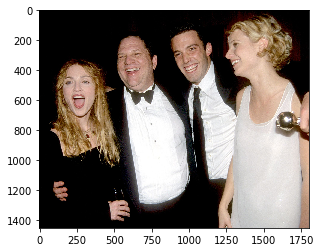

image loaded
3 Face has been detected




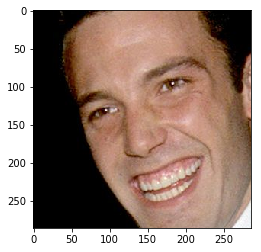

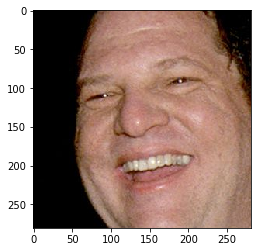

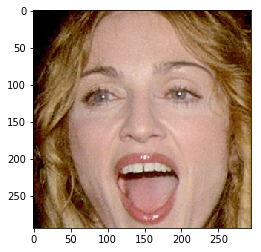


Prediction results:
Identity: ben_afflek, Prob 0.225047
Identity: elton_john, Prob 0.191868
Identity: jerry_seinfeld, Prob 0.238295
Identity: madonna, Prob 0.160593
Identity: mindy_kaling, Prob 0.184197
This face has been recognized as: jerry_seinfeld with prob 0.238295


Now search for the most similar Faces
displaying the top 3 ...


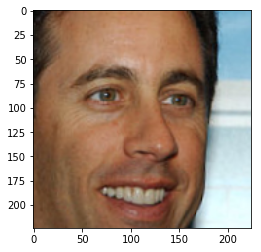

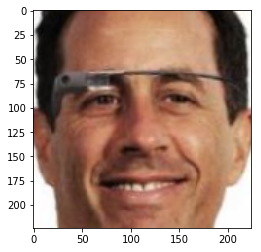

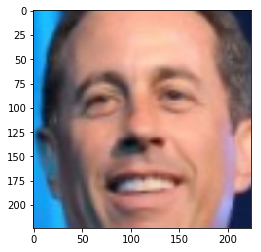


Prediction results:
Identity: ben_afflek, Prob 0.175317
Identity: elton_john, Prob 0.211141
Identity: jerry_seinfeld, Prob 0.190197
Identity: madonna, Prob 0.186056
Identity: mindy_kaling, Prob 0.237288
This face has been recognized as: mindy_kaling with prob 0.237288


Now search for the most similar Faces
displaying the top 3 ...


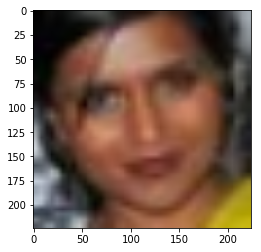

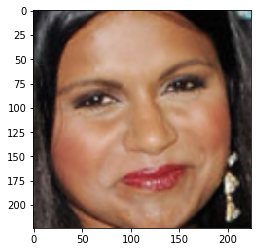

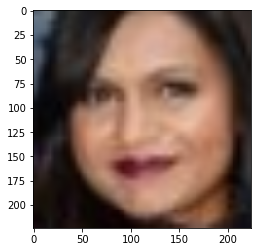


Prediction results:
Identity: ben_afflek, Prob 0.105061
Identity: elton_john, Prob 0.142646
Identity: jerry_seinfeld, Prob 0.160752
Identity: madonna, Prob 0.405807
Identity: mindy_kaling, Prob 0.185734
This face has been recognized as: madonna with prob 0.405807


Now search for the most similar Faces
displaying the top 3 ...


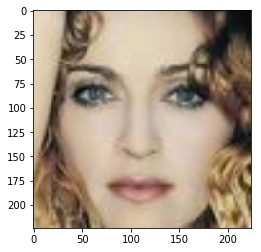

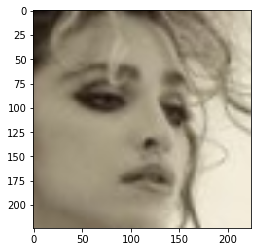

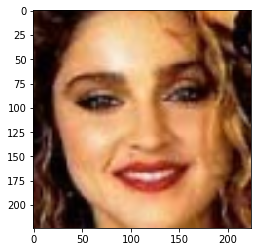

In [26]:
myFaceRecog_mul_1.predict_image_faces("images/ben_madonna.jpg")

loading image...


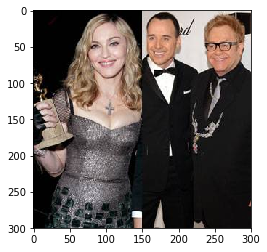

image loaded
3 Face has been detected




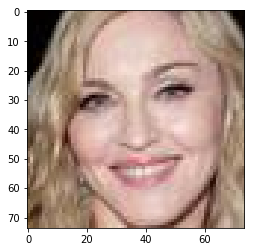

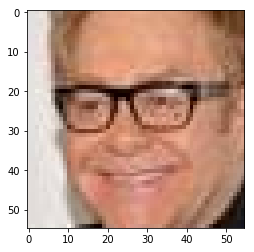

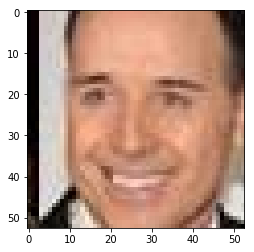


Prediction results:
Identity: ben_afflek, Prob 0.088688
Identity: elton_john, Prob 0.135186
Identity: jerry_seinfeld, Prob 0.125609
Identity: madonna, Prob 0.467486
Identity: mindy_kaling, Prob 0.183031
This face has been recognized as: madonna with prob 0.467486


Now search for the most similar Faces
displaying the top 3 ...


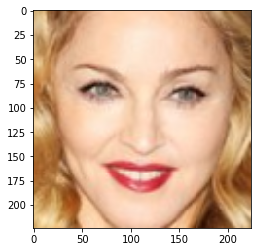

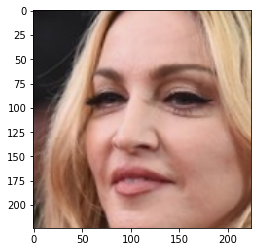

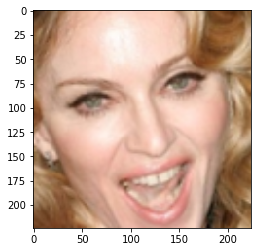


Prediction results:
Identity: ben_afflek, Prob 0.124445
Identity: elton_john, Prob 0.349288
Identity: jerry_seinfeld, Prob 0.177157
Identity: madonna, Prob 0.148635
Identity: mindy_kaling, Prob 0.200475
This face has been recognized as: elton_john with prob 0.349288


Now search for the most similar Faces
displaying the top 3 ...


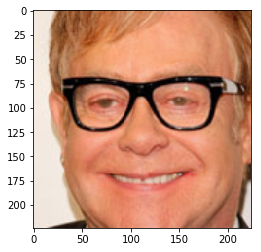

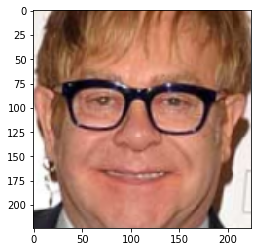

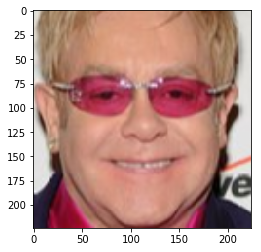


Prediction results:
Identity: ben_afflek, Prob 0.205109
Identity: elton_john, Prob 0.176301
Identity: jerry_seinfeld, Prob 0.279634
Identity: madonna, Prob 0.174914
Identity: mindy_kaling, Prob 0.164042
This face has been recognized as: jerry_seinfeld with prob 0.279634


Now search for the most similar Faces
displaying the top 3 ...


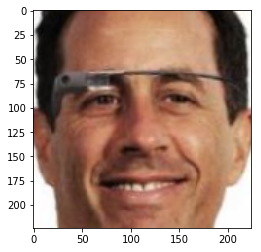

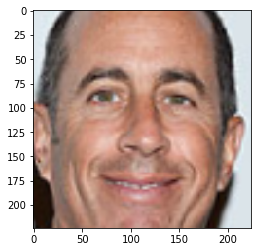

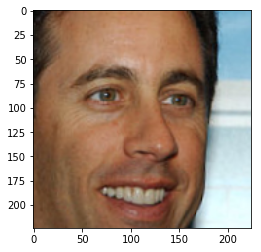

In [27]:
myFaceRecog_mul_1.predict_image_faces("images/madonna_elton.jpg")